In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

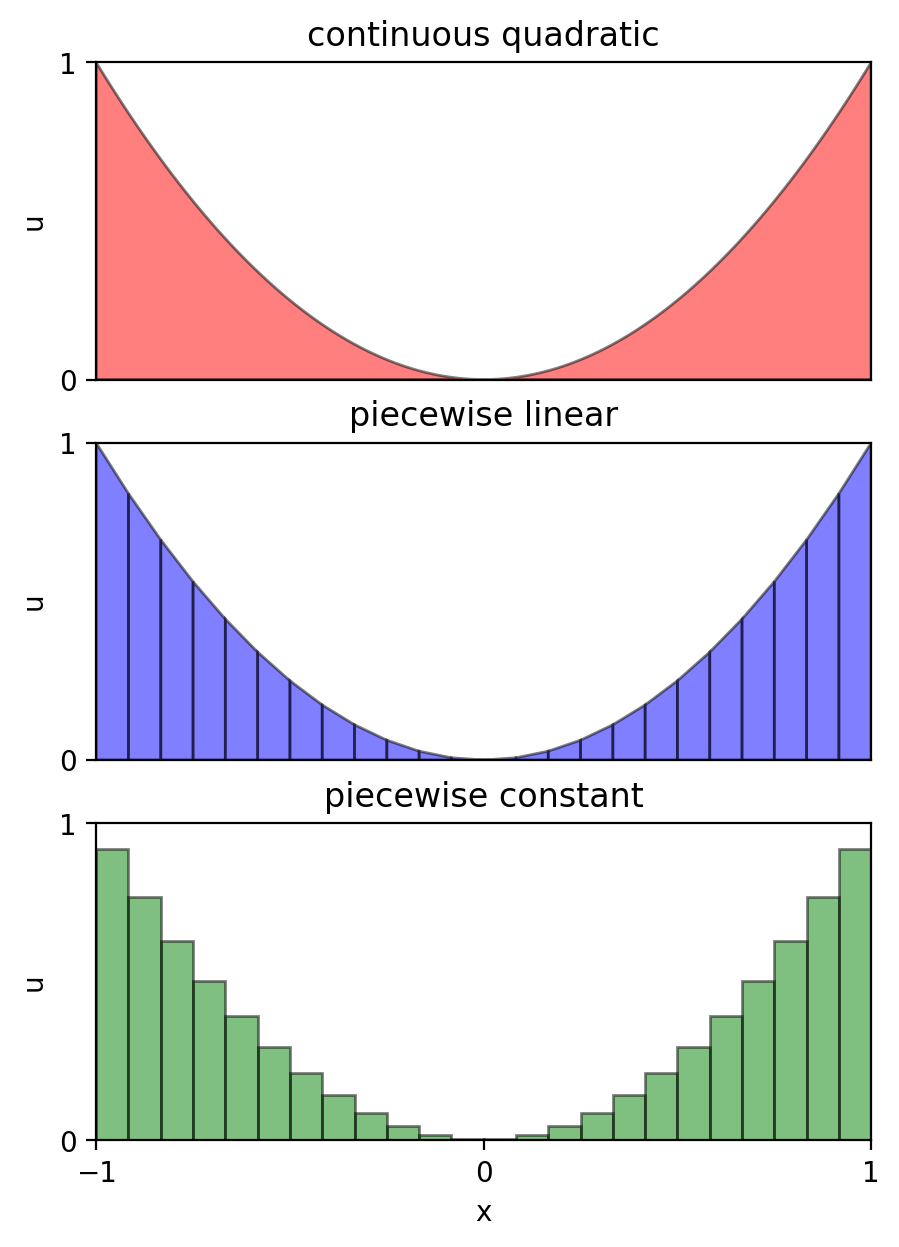

In [2]:
n_pts_high_resolution = 1000
n_pts_low_resolution = 25
n_els = n_pts_low_resolution - 1
x_high_resolution = np.linspace(-1, 1, n_pts_high_resolution)
x_low_resolution = np.linspace(-1, 1, n_pts_low_resolution)

# Define a quadratic
y_quadratic_high_resolution = x_high_resolution**2.0
y_quadratic_low_resolution = x_low_resolution**2.0

# Define a piecweise linear approximation to quadratic
linear_x1 = np.zeros(n_els)
linear_x2 = np.zeros(n_els)
linear_y1 = np.zeros(n_els)
linear_y2 = np.zeros(n_els)
for i in range(n_els):
    linear_x1[i] = x_low_resolution[i]
    linear_x2[i] = x_low_resolution[i + 1]
    linear_y1[i] = y_quadratic_low_resolution[i]
    linear_y2[i] = y_quadratic_low_resolution[i + 1]

# Define a piecewise constant apprximation to quadratic
constant_x1 = np.zeros(n_els)
constant_x2 = np.zeros(n_els)
constant_y1 = np.zeros(n_els)
constant_y2 = np.zeros(n_els)
for i in range(n_els):
    constant_x1[i] = x_low_resolution[i]
    constant_x2[i] = x_low_resolution[i + 1]
    constant_y1[i] = 0.5 * (
        y_quadratic_low_resolution[i] + y_quadratic_low_resolution[i + 1]
    )
    constant_y2[i] = 0.5 * (
        y_quadratic_low_resolution[i] + y_quadratic_low_resolution[i + 1]
    )

# Plot nearly continuous vs. piecewise linear and piecwise constant
plt.figure(figsize=(5, 7))

# High-resolution quadratic
plt.subplot(3, 1, 1)
plt.fill(
    np.append(x_high_resolution, [x_high_resolution[-1], x_high_resolution[0]]),
    np.append(y_quadratic_high_resolution, [0, 0]),
    "-r",
    alpha=0.5,
    edgecolor="k",
    label="quadratic",
)
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("continuous quadratic")

# Linear slip elements
plt.subplot(3, 1, 2)
for i in range(n_els):
    if i == 0:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
            label="piecewise linear",
        )
    else:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
        )

plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("piecewise linear")

# Constant slip elements
plt.subplot(3, 1, 3)
for i in range(n_els):
    if i == 0:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
            label="piecewise constant",
        )
    else:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
        )
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([-1, 0, 1])
plt.yticks([0, 1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("piecewise constant")
plt.show()

# Define geometry of single element model

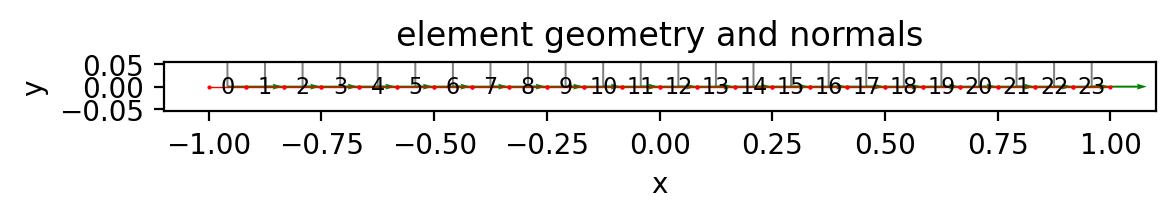

In [3]:
# List of elements for forward model
mu = 3e10
nu = 0.25
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_els)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Observation coordinates

In [4]:
x_obs = els.x_centers
y_obs = 1e-10 * np.ones_like(x_obs)

# Profile plotting

In [5]:
def plot_line_values(x, displacements, stresses, suptitle_string):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 2)
    plt.plot(x, displacements[0, :])
    plt.title("x displacement")

    plt.subplot(2, 3, 3)
    plt.plot(x, displacements[1, :])
    plt.title("y displacement")

    plt.subplot(2, 3, 4)
    plt.plot(x, np.log10(np.abs(stresses[0, :])))
    plt.title("xx stress")

    plt.subplot(2, 3, 5)
    plt.plot(x, np.log10(np.abs(stresses[1, :])))
    plt.title("yy stress")

    plt.subplot(2, 3, 6)
    plt.plot(x, np.log10(np.abs(stresses[2, :])))
    plt.title("xy stress")

    plt.suptitle(suptitle_string)

# Approximation with constant slip elements

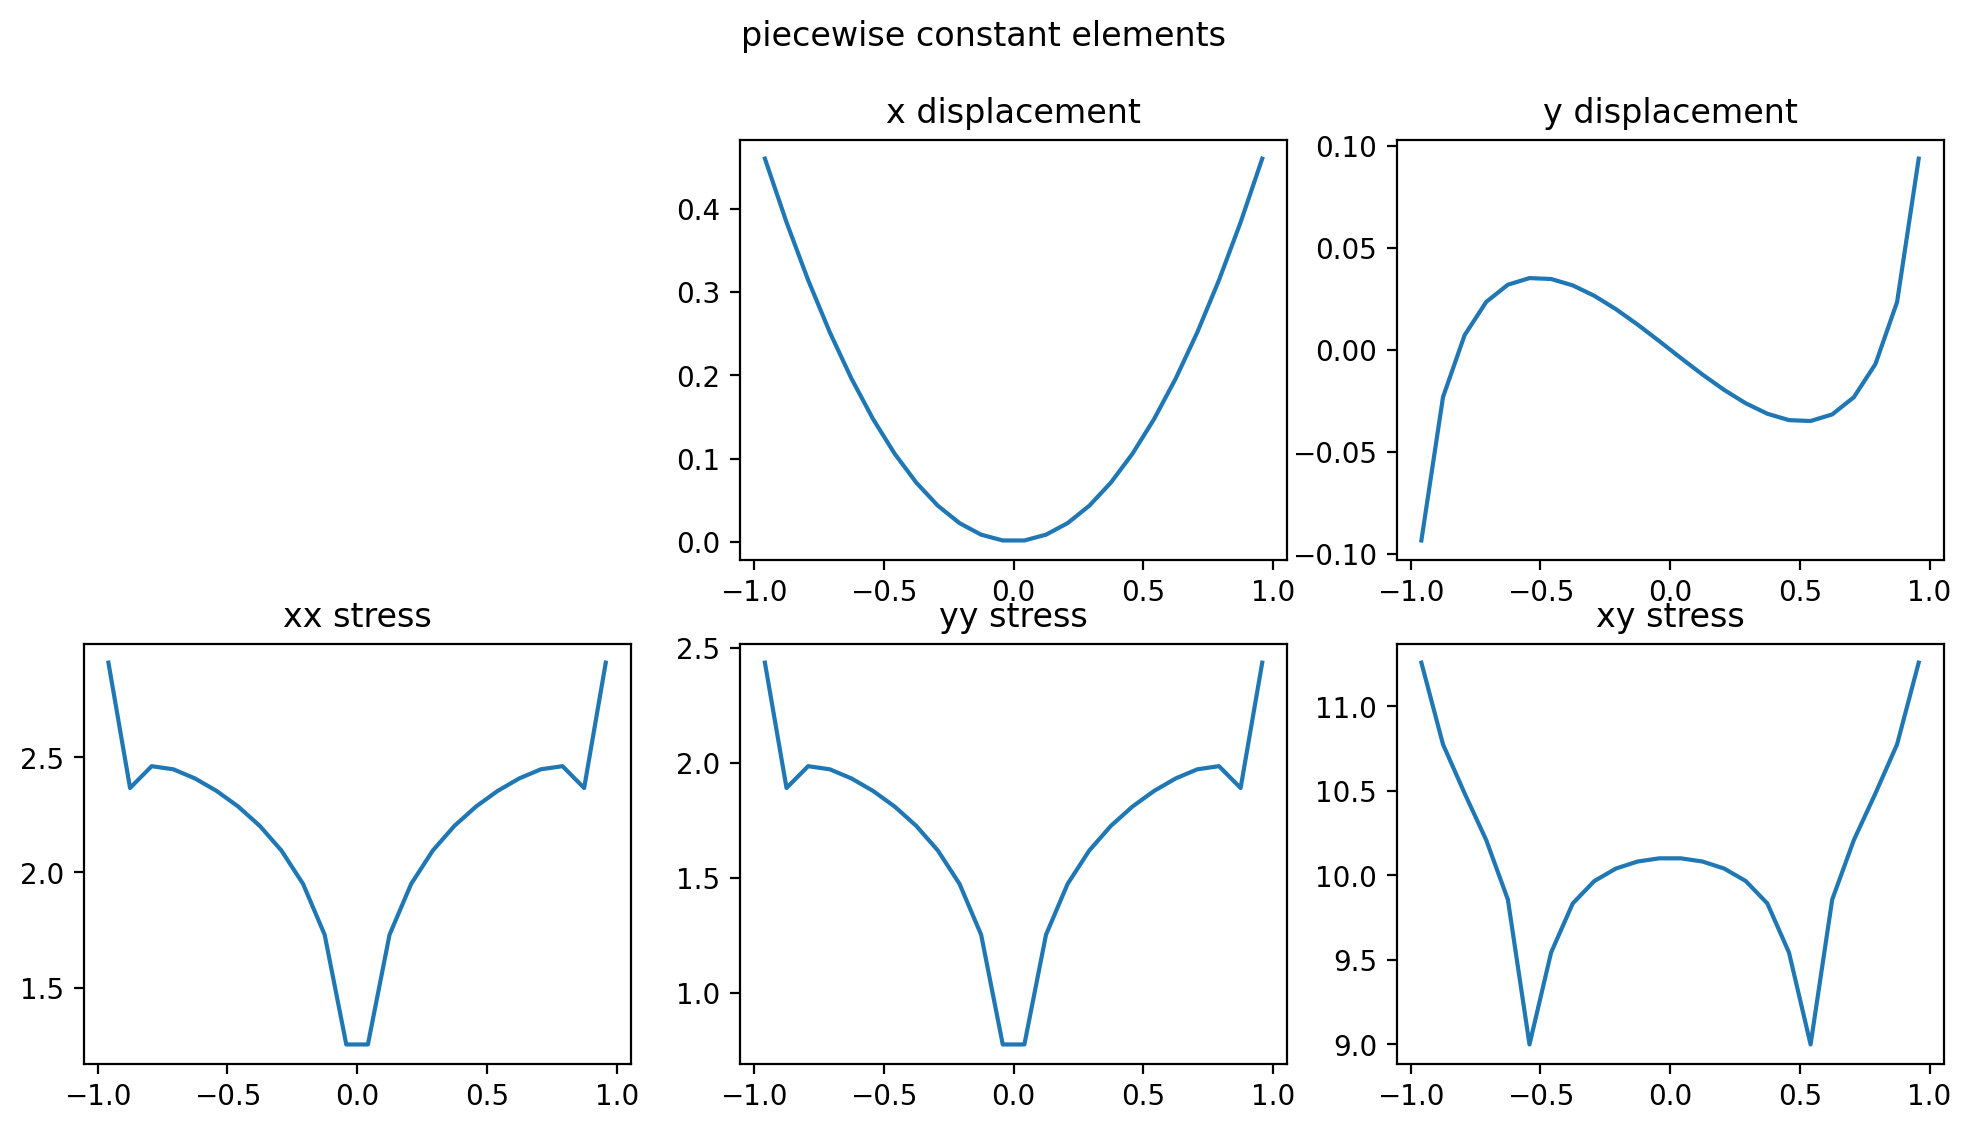

In [6]:
strike_slip_constant = np.copy(constant_y1)
tensile_slip_constant = 0

displacement_constant_total = np.zeros((2, n_els))
stress_constant_total = np.zeros((3, n_els))
for i in range(n_els):
    (
        displacement_constant,
        stress_constant,
    ) = bemcs.displacements_stresses_constant_no_rotation(
        x_obs,
        y_obs,
        els.half_lengths[i],
        mu,
        nu,
        strike_slip_constant[i],
        tensile_slip_constant,
        els.x_centers[i],
        els.y_centers[i],
    )
    displacement_constant_total += displacement_constant
    stress_constant_total += stress_constant

plot_line_values(
    x_obs,
    displacement_constant_total,
    stress_constant_total,
    "piecewise constant elements",
)

# Approximation with linear slip elements

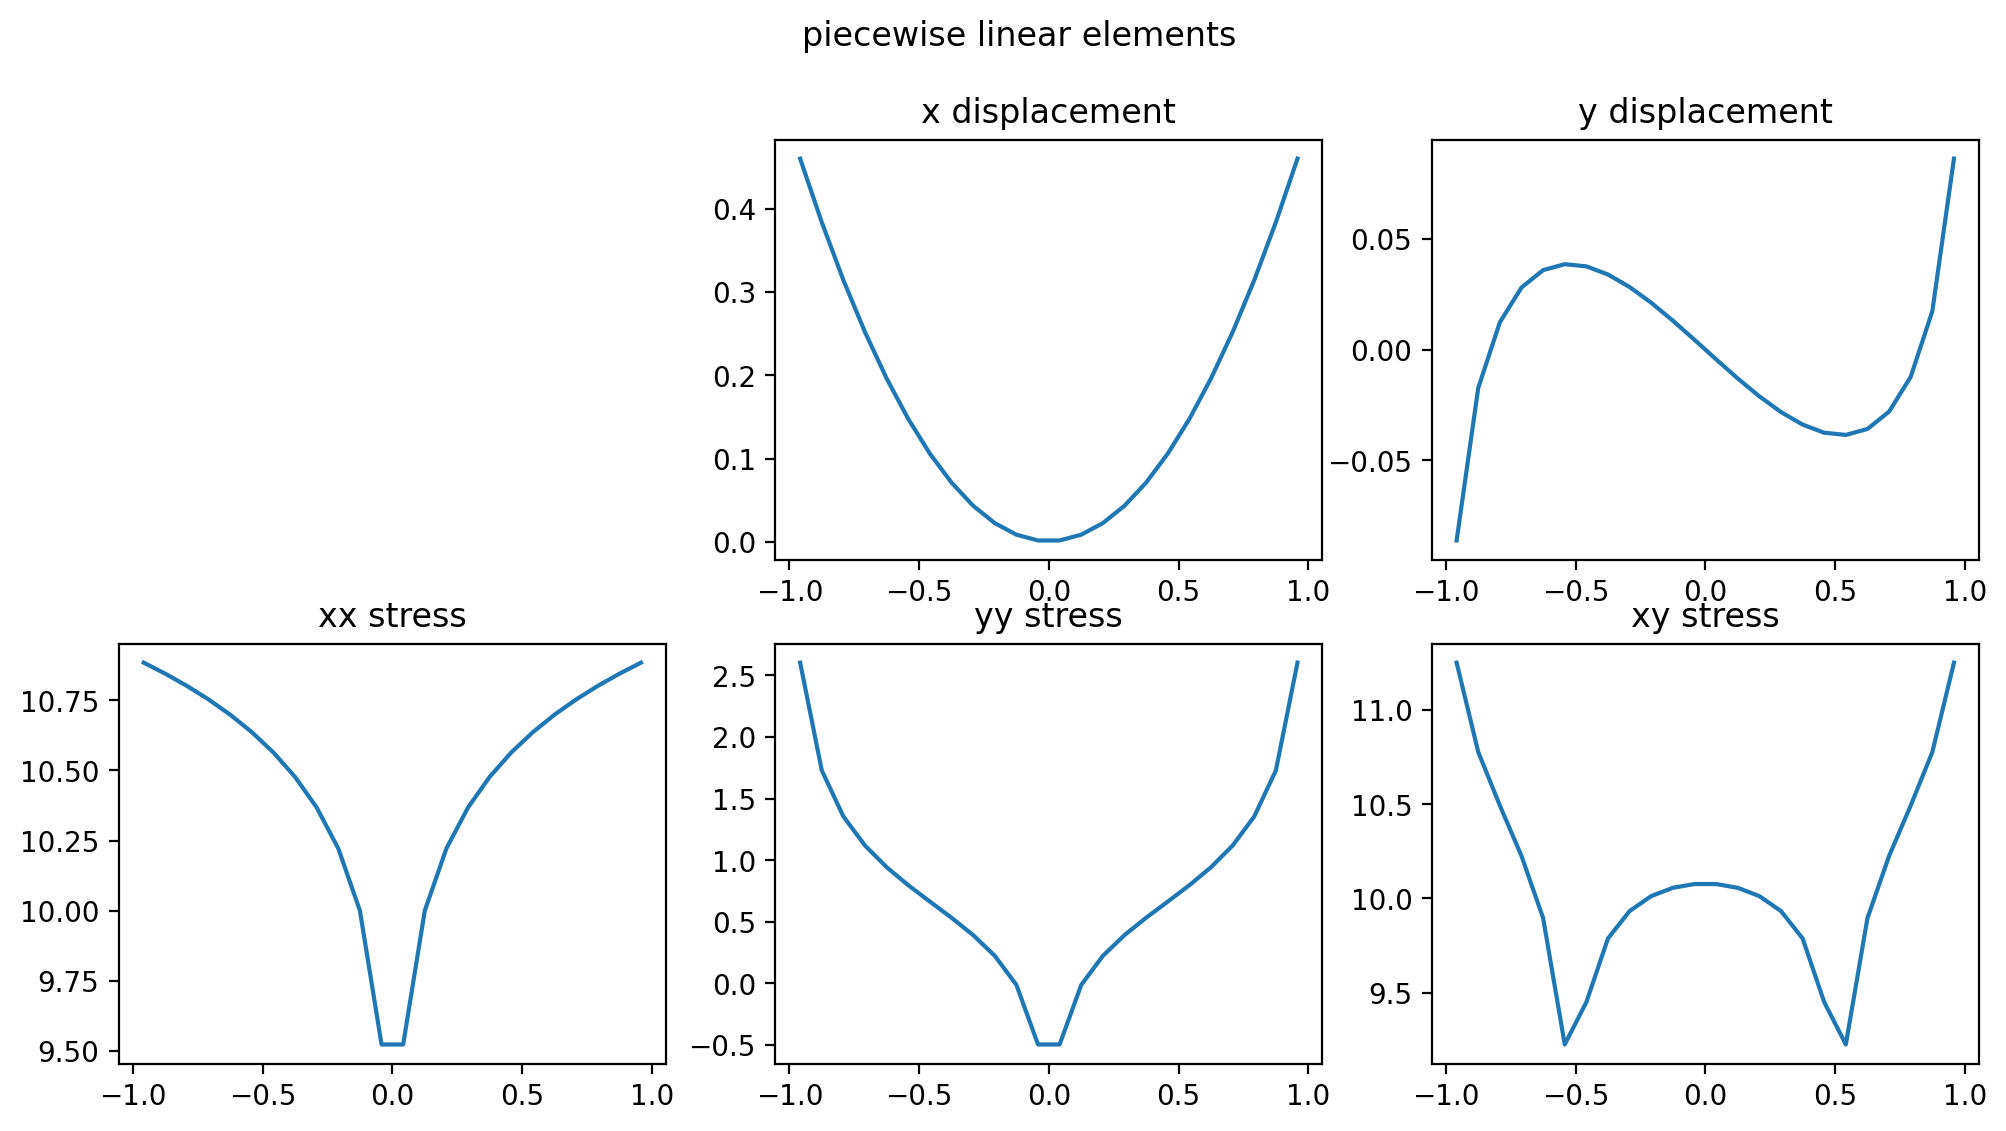

In [7]:
displacement_linear_total = np.zeros((2, n_els))
stress_linear_total = np.zeros((3, n_els))

for i in range(n_els):
    # Calculate quadratic weights for linear slip
    node_coordinates = (
        np.array([els.x1[i], els.x_centers[i], els.x2[i]]) - els.x_centers[i]
    )
    element_half_length = els.half_lengths[i]
    end_displacement_1 = linear_y1[i]
    end_displacement_2 = linear_y2[i]
    quadratic_coefficients = bemcs.get_quadratic_coefficients_for_linear_slip(
        element_half_length, node_coordinates, end_displacement_1, end_displacement_2
    )
    strike_slip_linear = np.copy(quadratic_coefficients)
    tensile_slip_linear = [0.0, 0.0, 0.0]

    # Calculate displacements and stresses for current element
    (
        displacement_linear,
        stress_linear,
    ) = bemcs.displacements_stresses_quadratic_no_rotation(
        x_obs,
        y_obs,
        els.half_lengths[i],
        mu,
        nu,
        strike_slip_linear,
        tensile_slip_linear,
        els.x_centers[i],
        els.y_centers[i],
    )

    # Add current element contribution to total
    displacement_linear_total += displacement_linear
    stress_linear_total += stress_linear

plot_line_values(
    x_obs,
    displacement_linear_total,
    stress_linear_total,
    "piecewise linear elements",
)

# Single quadratic slip element

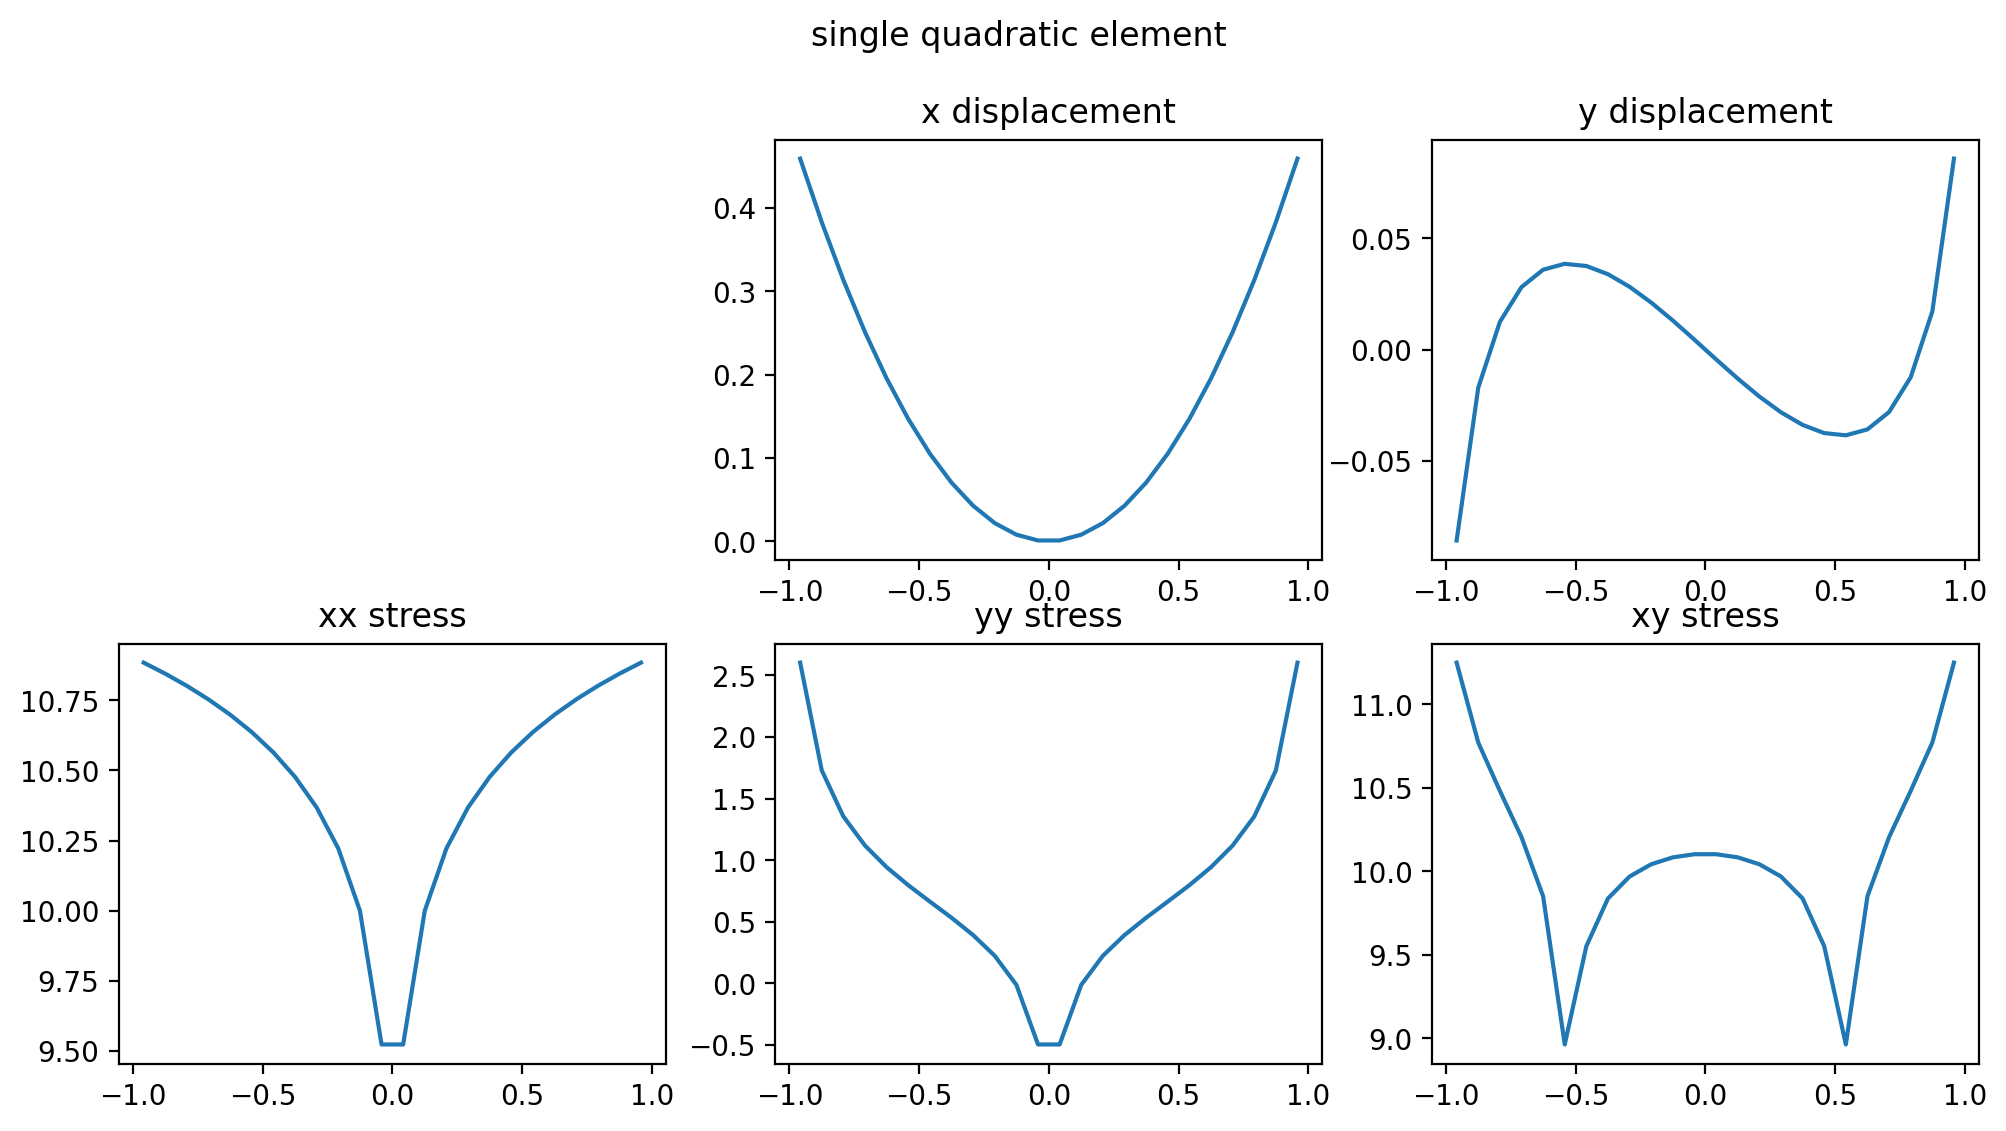

In [8]:
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, 1)
els_single = bemcs.initialize_els()
els_single.x1 = np.copy(x1)
els_single.y1 = np.copy(y1)
els_single.x2 = np.copy(x2)
els_single.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els_single)

quadratic_weights = bemcs.phicoef(np.array([-L, 0, L]), np.array([1, 0, 1]), L)
strike_slip_quadratic = np.copy(quadratic_weights)
tensile_slip_quadratic = [0.0, 0.0, 0.0]

(
    displacement_quadratic,
    stress_quadratic,
) = bemcs.displacements_stresses_quadratic_no_rotation(
    x_obs,
    y_obs,
    els_single.half_lengths[0],
    mu,
    nu,
    strike_slip_quadratic,
    tensile_slip_quadratic,
    els_single.x_centers[0],
    els_single.y_centers[0],
)

plot_line_values(
    x_obs,
    displacement_quadratic,
    stress_quadratic,
    "single quadratic element",
)

# Plot comparisons

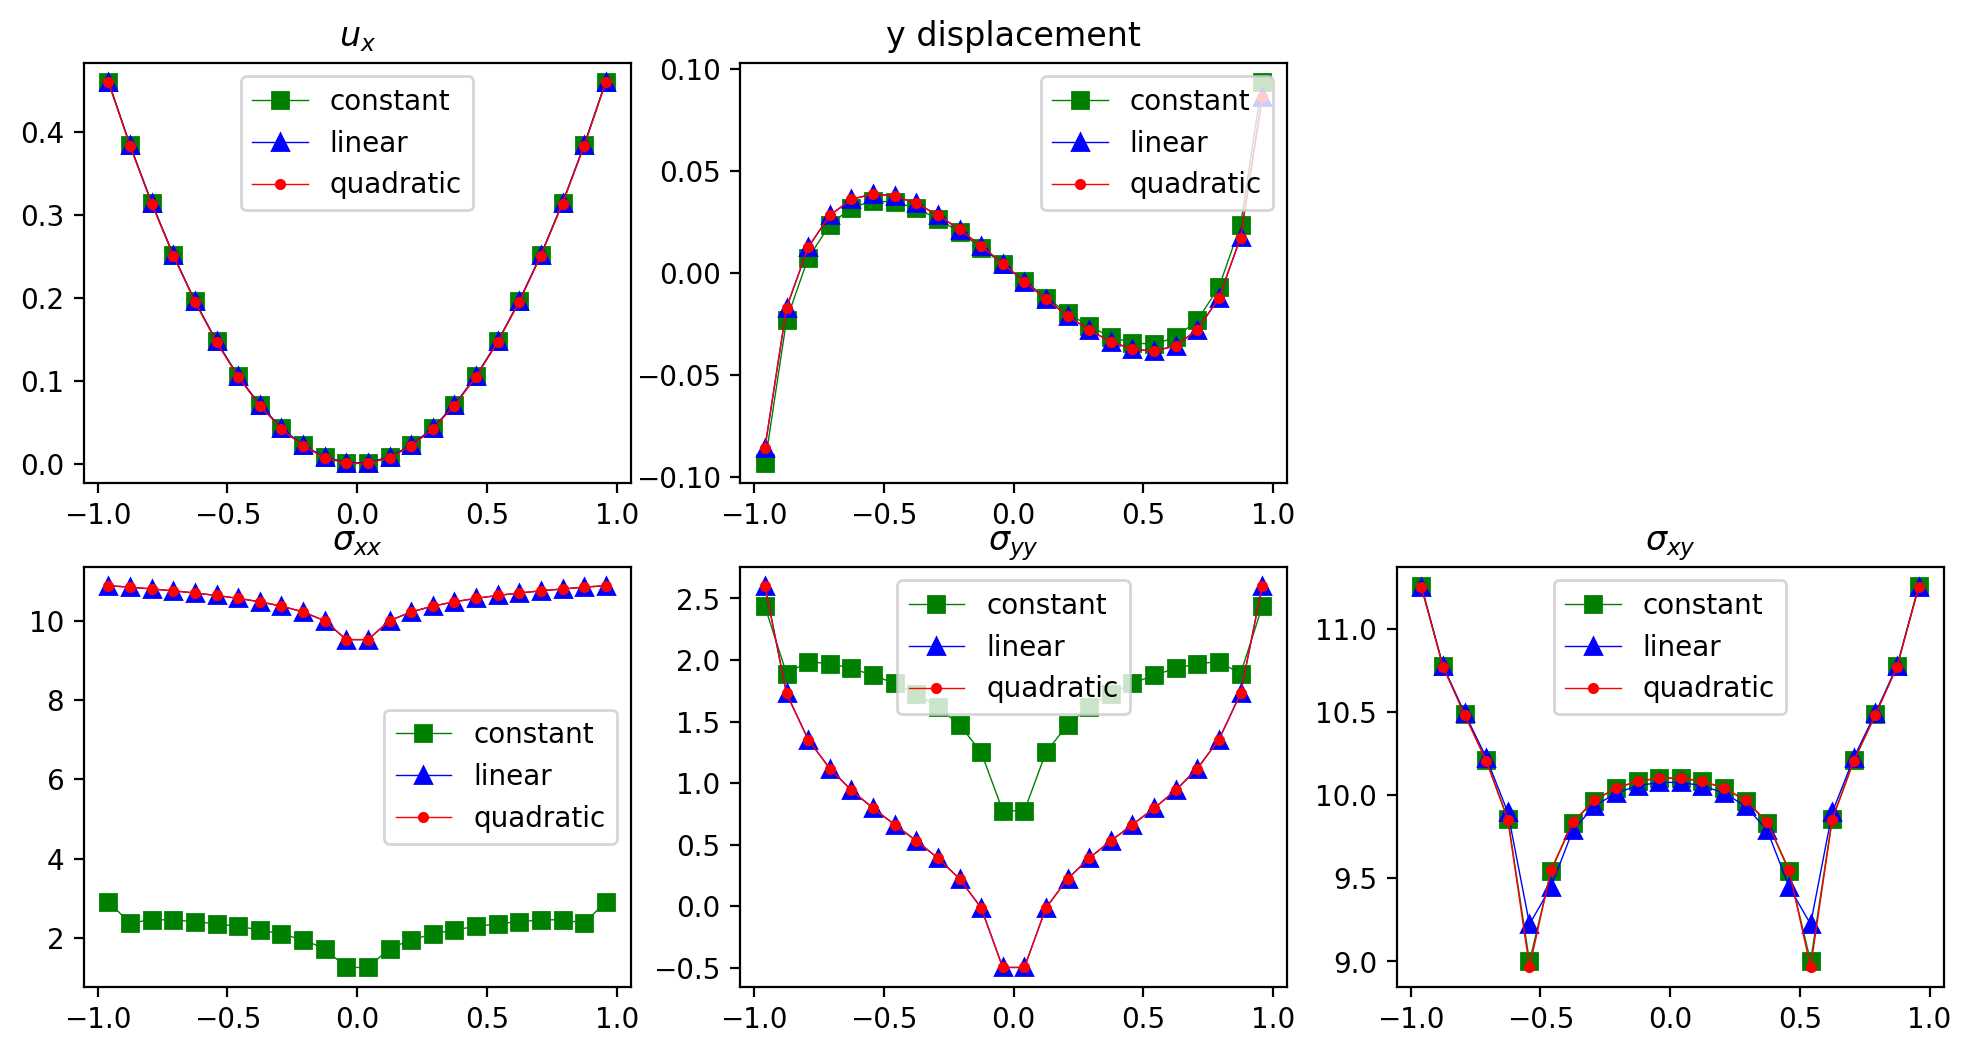

In [40]:
line_width = 0.5

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(
    x_obs,
    displacement_constant_total[0, :],
    "-gs",
    linewidth=line_width,
    label="constant",
)
plt.plot(
    x_obs, displacement_linear_total[0, :], "-b^", linewidth=line_width, label="linear"
)
plt.plot(
    x_obs, displacement_quadratic[0, :], "-r.", linewidth=line_width, label="quadratic"
)
plt.legend()
plt.title("$u_x$")

plt.subplot(2, 3, 2)
plt.plot(
    x_obs,
    displacement_constant_total[1, :],
    "-gs",
    linewidth=line_width,
    label="constant",
)
plt.plot(
    x_obs, displacement_linear_total[1, :], "-b^", linewidth=line_width, label="linear"
)
plt.plot(
    x_obs, displacement_quadratic[1, :], "-r.", linewidth=line_width, label="quadratic"
)
plt.legend()
plt.title("y displacement")

plt.subplot(2, 3, 4)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_constant_total[0, :])),
    "-gs",
    linewidth=line_width,
    label="constant",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_linear_total[0, :])),
    "-b^",
    linewidth=line_width,
    label="linear",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_quadratic[0, :])),
    "-r.",
    linewidth=line_width,
    label="quadratic",
)
plt.legend()
plt.title("$\sigma_{xx}$")

plt.subplot(2, 3, 5)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_constant_total[1, :])),
    "-gs",
    linewidth=line_width,
    label="constant",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_linear_total[1, :])),
    "-b^",
    linewidth=line_width,
    label="linear",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_quadratic[1, :])),
    "-r.",
    linewidth=line_width,
    label="quadratic",
)
plt.legend()
plt.title("$\sigma_{yy}$")

plt.subplot(2, 3, 6)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_constant_total[2, :])),
    "-gs",
    linewidth=line_width,
    label="constant",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_linear_total[2, :])),
    "-b^",
    linewidth=line_width,
    label="linear",
)
plt.plot(
    x_obs,
    np.log10(np.abs(stress_quadratic[2, :])),
    "-r.",
    linewidth=line_width,
    label="quadratic",
)
plt.legend()
plt.title("$\sigma_{xy}$")

plt.show()